<a href="https://colab.research.google.com/github/silviazandoli/explanaible_ai/blob/master/3_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


**Chapter 3 - Intrinsic Explainable Models - Decision Trees**

gianfagna_l_di_cecco_a_explainable_ai_with_python (Book)

- we use a decision tree ML model to predict the survival
probabilities. The insurance company is asked to provide explanations and criteria
to back up the survival rates, and we will show how to get them.

Permutation Importance - Post hoc

In [39]:
#download from here
#https://github.com/mwaskom/seaborn-data/blob/master/titanic.csv

titanic = pd.read_csv('titanic.csv')

#Print the first 10 rows of data
titanic.head(10)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
5,0,3,male,NaN,0,0,8.4583,Q,Third,man,True,NaN,Queenstown,no,True
6,0,1,male,54.0,0,0,51.8625,S,First,man,True,E,Southampton,no,True
7,0,3,male,2.0,3,1,21.0750,S,Third,child,False,NaN,Southampton,no,False
8,1,3,female,27.0,0,2,11.1333,S,Third,woman,False,NaN,Southampton,yes,False
9,1,2,female,14.0,1,0,30.0708,C,Second,child,False,NaN,Cherbourg,yes,False


pre-elaboration- cancel NaN values! La colonna Deck contiene valori NaN. Dobbiamo togliere questi NaN, il DecisionTreeClassifier non li supporta! Stessa cosa per Age!

In [40]:
from sklearn.impute import SimpleImputer
#
# Missing values is represented using NaN and hence specified. If it
# is empty field, missing values will be specified as ''
#
imputer = SimpleImputer(missing_values=np.NaN, strategy='most_frequent')

titanic.deck = imputer.fit_transform(titanic['deck'].values.reshape(-1,1))[:,0]
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')

titanic.age = imputer.fit_transform(titanic['age'].values.reshape(-1,1))[:,0]
titanic

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.000000,1,0,7.2500,S,Third,man,True,C,Southampton,no,False
1,1,1,female,38.000000,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.000000,0,0,7.9250,S,Third,woman,False,C,Southampton,yes,True
3,1,1,female,35.000000,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.000000,0,0,8.0500,S,Third,man,True,C,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S,Second,man,True,C,Southampton,no,True
887,1,1,female,19.000000,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,29.699118,1,2,23.4500,S,Third,woman,False,C,Southampton,no,False
889,1,1,male,26.000000,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [41]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
##Encode sex column
titanic.iloc[:,2]= labelencoder.fit_transform(titanic.
iloc[:,2].values)

#Split the data into independent 'X' and dependent 'Y'variables
X_values = titanic.iloc[:, 1:4].values
Y_values = titanic.iloc[:, 0].values #survived
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_values, Y_values, test_size=0.2, random_state=42)

<ipython-input-41-be2301b63669>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  titanic.iloc[:,2]= labelencoder.fit_transform(titanic.


Train the model

In [42]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz
tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train, Y_train)
#output of training
DecisionTreeClassifier(class_weight=None, criterion='gini',max_depth=3,
max_features=None, max_leaf_nodes=None,
min_impurity_decrease=0.0,
min_samples_leaf=1, min_samples_split=2,
min_weight_fraction_leaf=0.0,
random_state=None, splitter='best')

DecisionTreeClassifier(max_depth=3)

In [43]:
# Making predictions
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)

# Calculate the accuracy
from sklearn.metrics import accuracy_score
train_accuracy = accuracy_score(Y_train, y_train_pred)
test_accuracy = accuracy_score(Y_test, y_test_pred)
print('The training accuracy is', train_accuracy)
print('The test accuracy is', test_accuracy)

The training accuracy is 0.8103932584269663
The test accuracy is 0.8044692737430168


In [44]:
!pip install graphviz

Decision tree to predict survival rates based on the different features

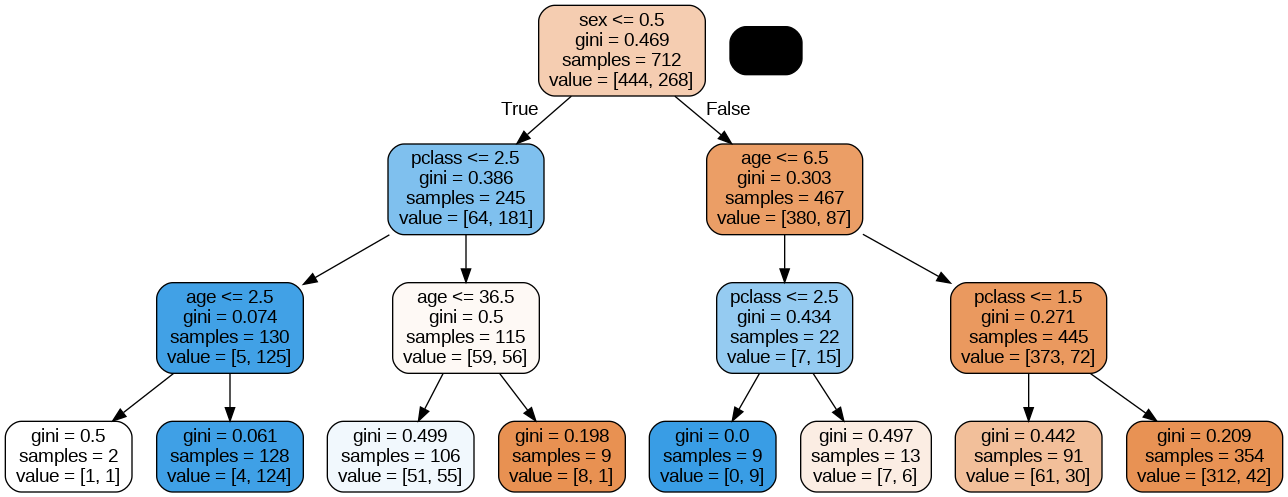

In [48]:
from IPython.display import Image
from six import StringIO
from sklearn.tree import export_graphviz
import pydot
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,feature_names=['pclass','sex','age'],filled=True,rounded=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
Image(graph[0].create_png())


Look at the decision tree graph. Each node (rectangle) contains both survived
and not-survived passengers.  The first split puts women on the left and
men on the right.
Now in the two subsets, the women subset has a majority who has survived. The
second split is on age, and we see that in the male subset on the right splitting by age
tells us that male children have a higher chance to survive.

Permutation Importance in its simplicity is a post hoc procedure. We check the model workings against some test dataset AFTER the training process
of the model.

It calculates features importance.

In [13]:
!pip install eli5

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107719 sha256=7229c7c034e0b9340a08595fdfc567f393e6f5d150bb35419a4b8f3bbd6879ba
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
Successfully built eli5


In [49]:
import eli5
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(tree, random_state=1).fit(X_train, Y_train)
eli5.show_weights(perm, feature_names=['pclass','sex','age'])

Weight,Feature
0.2551 ± 0.0508,sex
0.0416 ± 0.0137,pclass
0.0385 ± 0.0161,age


So sex is more critical than others

Recap:


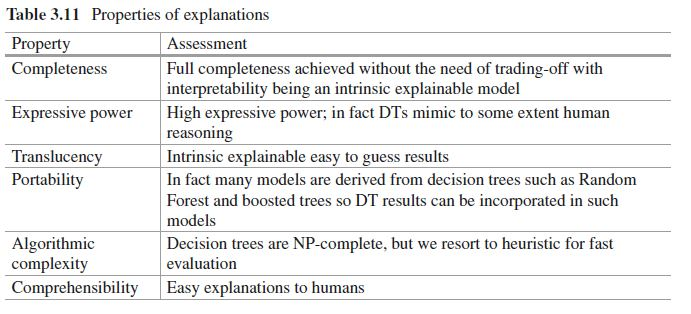